# Détection de la position d'un usager par apprentissage artificielle

In [1]:
from src.plot import openImage
from src.plot import plot_position
import matplotlib.pyplot as plt

Plan du batiment

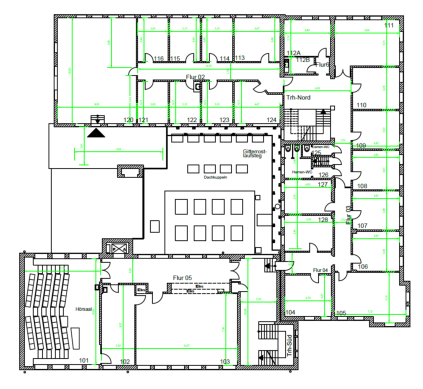

In [2]:
ECHELLE = 100
image_batiment = openImage("./images/batiment.png")

plt.imshow(image_batiment)
plt.axis("off")
plt.show()

#### Chargement des signaux collectés par position

In [3]:
from src.load import load_collected_positions_2d
P, D = load_collected_positions_2d("./datas/without_acces/BSSIDs_collected.csv")

Visualisation des positions où les signaux ont été collectés

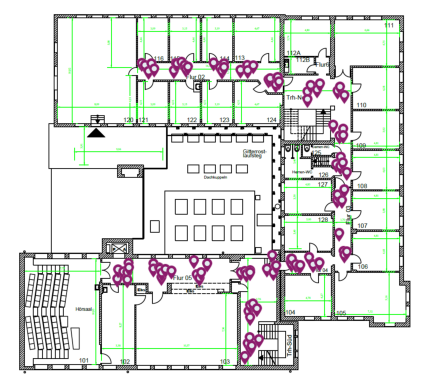

In [4]:
image = openImage("./images/batiment.png")
for M in P:
    image = plot_position(
        M,
        None,
        "./images/pointeur_violet.png",
        image=image,
        echelle=ECHELLE,
        showed=False,
    )

plt.imshow(image)
plt.axis("off")
plt.show()

#### Pretraitement des groupes de signaux

* Transformation des groupes de signaux en vecteur avec `DictVectorizer`
* Normalisation des vecteurs obtenus en utilisant `StandardScaler`

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

preModel = Pipeline(
    [("DicVect", DictVectorizer(sparse=False)), ("Scaler", StandardScaler())]
)
datas = preModel.fit_transform(D)
datas.shape

(104, 164)

#### Construction et choix du modèle a utilisé

Il est important que le modèle :
* Soit explicable
* Possède une inférence de complexité linéaire

##### Modèles utilisables

In [6]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor


def DecisionTree():
    return DecisionTreeRegressor()

def KNN():
    return KNeighborsRegressor()

def XGBoost():
    return XGBRegressor()


def CatBoost():
    return MultiOutputRegressor(CatBoostRegressor())


regressors = {
    "KNN": KNN,
    "DecisionTree": DecisionTree,
    "XGBoost": XGBoost,
    "CatBoost": CatBoost,
}

##### Evaluation des modèles utilisables sur la datset (`Cross Validation`)

Metriques d'évaluation

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)


def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)


def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)
    
metrics = {
    "rmse": rmse,
    "mse": mse,
    "mae": mae,
    "r2": r2_score
}

is_best_greatest = {
    "rmse": False,
    "mse": False,
    "mae": False,
    "r2": True,
}

Evaluation des modèles proprement dit

In [8]:
from sklearn.model_selection import KFold
from numpy import mean
from pandas import DataFrame

kf = KFold(n_splits=10, shuffle=True, random_state=42)

perfs = {
    name_model: {name_metric: [] for name_metric in metrics.keys()}
    for name_model in regressors.keys()
}

for train_index, test_index in kf.split(datas):
    X_train, X_test = datas[train_index], datas[test_index]
    y_train, y_test = P[train_index], P[test_index]

    for name_model in regressors.keys():
        regressor = regressors[name_model]()
        model = regressor.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        for name_metric in metrics.keys():
            metric = metrics[name_metric](y_test, y_pred)
            perfs[name_model][name_metric].append(metric)

pfs = []
for name_model in regressors.keys():
    perf_model = {"model": name_model}
    for name_metric in metrics.keys():
        perf_model[name_metric] = round(mean(perfs[name_model][name_metric]),3)
    pfs.append(perf_model)

df = DataFrame(pfs).set_index("model")

for name_metric in df.columns:
    if not is_best_greatest[name_metric]:
        df[name_metric] = df[name_metric].apply(lambda x: -x)

df = df.sort_values([name_metric for name_metric in metrics], ascending=False)

for name_metric in df.columns:
    if not is_best_greatest[name_metric]:
        df[name_metric] = df[name_metric].apply(lambda x: -x)


Learning rate set to 0.028132
0:	learn: 1.6965839	total: 49.2ms	remaining: 49.2s
1:	learn: 1.6664597	total: 50.9ms	remaining: 25.4s
2:	learn: 1.6345486	total: 52ms	remaining: 17.3s
3:	learn: 1.6065841	total: 53ms	remaining: 13.2s
4:	learn: 1.5774127	total: 69.3ms	remaining: 13.8s
5:	learn: 1.5441408	total: 69.9ms	remaining: 11.6s
6:	learn: 1.5136171	total: 70.8ms	remaining: 10s
7:	learn: 1.4864215	total: 71.4ms	remaining: 8.85s
8:	learn: 1.4596964	total: 71.8ms	remaining: 7.91s
9:	learn: 1.4322085	total: 73.7ms	remaining: 7.3s
10:	learn: 1.4033510	total: 83ms	remaining: 7.46s
11:	learn: 1.3796591	total: 83.9ms	remaining: 6.91s
12:	learn: 1.3567775	total: 84.7ms	remaining: 6.43s
13:	learn: 1.3324245	total: 85.4ms	remaining: 6.01s
14:	learn: 1.3063453	total: 86.2ms	remaining: 5.66s
15:	learn: 1.2834231	total: 87.1ms	remaining: 5.36s
16:	learn: 1.2605294	total: 96.5ms	remaining: 5.58s
17:	learn: 1.2387506	total: 97.3ms	remaining: 5.31s
18:	learn: 1.2205331	total: 98.1ms	remaining: 5.06s
1

In [9]:
df

,rmse,mse,mae,r2
model,,,,
DecisionTree,0.157,0.028,0.124,0.990
XGBoost,0.157,0.028,0.124,0.990
CatBoost,0.157,0.028,0.124,0.990
KNN,0.265,0.077,0.198,0.971


##### Selection et Entrainement du meilleur modèle

In [10]:
name_best_model = df.index[0]
print(f" Meilleure Modèle : {name_best_model}")
model = regressors[name_best_model]()

 Meilleure Modèle : DecisionTree


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(datas, P, train_size=0.8)

model.fit(X_train, y_train)
score = model.score(X_test, y_test)

# R2
print(score)

0.9943322056545827


#### Sauvegarde et utilisation du modèle le plus performant

In [12]:
model_complet = Pipeline([("preModel", preModel), ("model", model)])

In [13]:
# sauvegarde du model
from pickle import dump

with open("detect_model.pkl", "wb") as files:
    dump(model_complet, files)

In [14]:
from src.load import load_collected_user

usager = load_collected_user("./datas/without_acces/BSSID_user.csv")

In [15]:
model_complet.predict(usager)

array([[8.2325, 3.8775]])

In [16]:
# chargement et utilisation du modèle sauvegardé
from pickle import load

with open("detect_model.pkl", "rb") as f:
    detect_model = load(f)

In [17]:
M = detect_model.predict(usager)[0]

[position détectée]  
 M (x : 8.232500000000002, y : 3.8775)


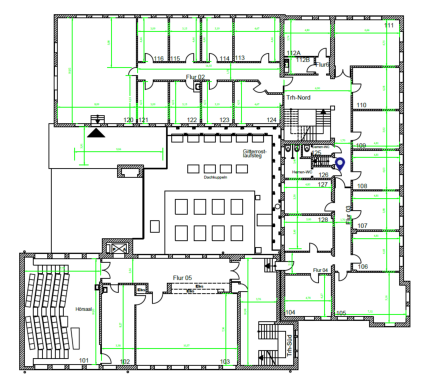

In [18]:
from src.plot import plot_position

print("[position détectée]  ")
print(f" M (x : {M[0]}, y : {M[1]})")

image = plot_position(
    M,
    None,
    "./images/pointeur.png",
    image=image_batiment,
    echelle=ECHELLE,
    showed=False,
)

plt.imshow(image)
plt.axis("off")
plt.show()